# Different data formats

This notebook shows some examples for loading file formats from different battery testers as well as some "tweaking" possibilites provided by `cellpy`. We hope that, as time goes, a more complete set of instruments will be fully supported. Loading non-supported ("custom") file formats is explained in more detail [here](./07_custom_loaders.ipynb).

In [1]:
from rich import print

import cellpy
from cellpy.utils import example_data, plotutils

In [2]:
# Comment out this when running the notebook locally to get interactive plots
import plotly.io as pio
pio.renderers.default = "png"

## Overview

To get an overview on all the implemented instruments/loaders:

In [32]:
from cellpy.readers import core
print(core.find_all_instruments().keys())

dict_keys(['arbin_res', 'arbin_sql', 'arbin_sql_7', 'arbin_sql_csv', 'arbin_sql_h5', 'arbin_sql_xlsx', 
'biologics_mpr', 'custom', 'ext_nda_reader', 'local_instrument', 'maccor_txt', 'neware_txt', 'neware_xlsx', 
'pec_csv'])

Some instruments have different types of `models` - for more details on those, have a look at the section on reading of *Maccor* data below.

Defining a simple utility-function to get a peek of the file in question:

In [3]:
def head(f, n=5):
    print(f" {f.name} ".center(80, "-"))
    with open(f) as datafile:
        for j in range(n):
            line = datafile.readline()
            print(f"[{j+1:02}] {line.strip()}")
        

## PEC CSV data

PEC testers do not seem to allow direct access to the raw data (database). However, data can be exported to csv-files from the graphical user interface. There might exist other solutions as well (let us know). 

`cellpy` contains a limited set of example data sets, among others, a csv-file exported from a run performed at a PEC tester. The example data can be downloaded to your PC using the `utils.example_data` module:

In [4]:
p = example_data.pec_file_path()
print(f"{p.name=}")

p.name='pec.csv'

Below we take a look at the first 35 lines of the example PEC csv-files.

If the file you want to load is not similar to this, either a custom loader must be made, or you can create an issue on GitHub (and maybe help in implementing the necessery modifications?). 

In [5]:
head(p, 35)

----------------------------------- pec.csv ------------------------------------

[01] Request Year:,2019

[02] Test:,187

[03] Test Description:,

[04] TestRegime Name:,FirstCell dQdV C/25

[05] TestRegime Suffix:,HWL

[06] TestRegime CellSize:,Default cellsize

[07] TestRegime Version:,1

[08] Project Group Name:,Immediate

[09] Project Group Description:,Immediate

[10] Project Group Memo:,

[11] Project Group Storage Environment:,R.T./AMB

[12] Project Group Test Environment:,R.T./AMB

[13] Number Of Cells:,1

[14] Parameter names:,

[15] Parameter values:,

[16] Variable names:

[17] LotID:,

[18] Lot Description:,

[19] Date Made:,1/21/2003 0:00

[20] Origin:,Other

[21] Requestor:,Admin

[22] Product ID:,Default product

[23] Storage Temp:,R.T./AMB

[24] Storage Delay:,0 days

[25] Test Temp:,R.T./AMB

[26] Start Time:,02/22/2019 16:21:35

[27] End Time:,1/1/0001 0:00

[28] Operator Instructions:,Also connect cell temp to channel TC-K and ambient temp to NTC

[29] #RESULTS CHECK

[30] ReqYear,Test,CellNr,Type,Value,Reason,

[31] 2019,187,1,1,3272,3,

[32] #END RESULTS CHECK

[33] Test,Cell,Rack,Shelf,Position,Cell ID,Step,Cycle,Total Time (Seconds),Load On Time (Seconds),Step Time 
(Seconds),Cycle Charge Time (Seconds),Cycle Discharge Time (Seconds),Real Time,Position Start Time,Voltage 
(mV),Current (mA),Charge Capacity (mAh),Discharge Capacity (mAh),Charge Capacity (mWh),Discharge Capacity 
(mWh),ReasonCode,50% DoD (mV),PeakPower 1 (W),PeakPower 2 (W),Open Circuit Voltage 1 (V),Open Circuit Voltage 2 
(V),Internal Resistance 1 (mOhm),Internal Resistance 2 (mOhm),Ambient temperature (°C),Cell surface temperature 
(°C),DC Internal Resistance (mOhm),AC Internal Resistance (mOhm),Station Temperature (°C),

[34] 187,1,SBT0550,001,1,,0,0,1,0,1,0,0,02/22/2019 16:23:27,02/22/2019 
16:23:26,3272.632,0,0,0,0,0,30,0,0,0,0,0,0,0,25.83,24.9,,,,

[35] 187,1,SBT0550,001,1,,0,0,5,0,5,0,0,02/22/2019 16:23:31,02/22/2019 
16:23:26,3272.2776,0,0,0,0,0,30,0,0,0,0,0,0,0,25.83,24.9,,,,

### Loading the file

You can load the file using the `.get` method as usual. However, you will have to provide `cellpy` the name of the instrument (for this case it will be "pec_csv").

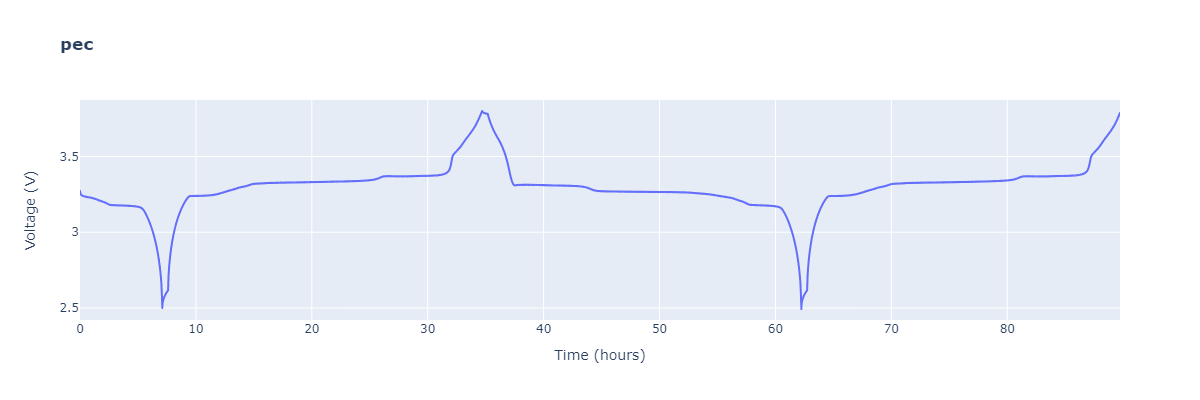

In [6]:
c = cellpy.get(p, instrument="pec_csv", cycle_mode="full_cell")
plotutils.raw_plot(c, width=1200, height=400)

Once you have loaded the files, you can use all the common functionalities of `cellpy` (as described in other example notebooks), such as, e.g., looking at a summary plot:

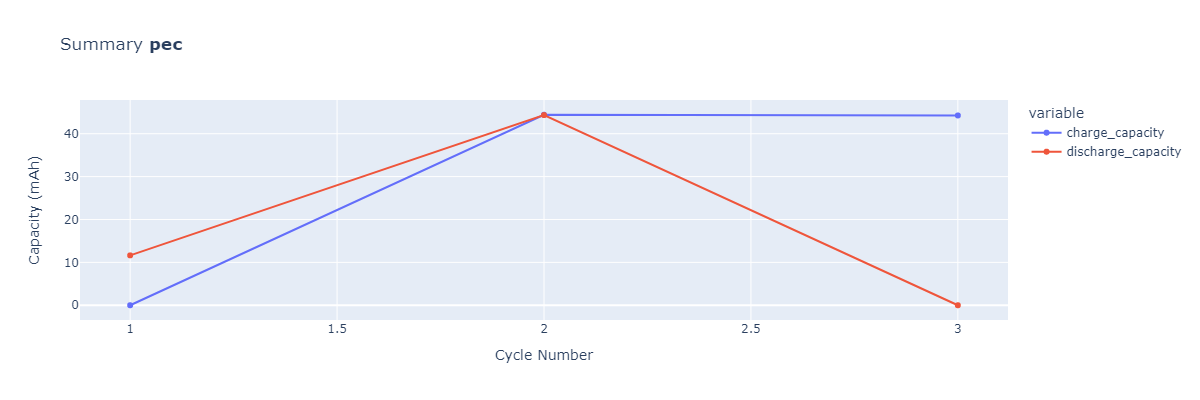

In [7]:
plotutils.summary_plot(c, y="capacities", width=1200, height=400)

## MACCOR

The implemented loader for exported data from Maccor is able to load several "file-morphologies" (so-called `models`). This illustrates one of the main weaknesses of not having direct access to the raw-data: the operator/user typically has the possibility select (consciously or not) how the final exported data file will look. This can be, for example, what to name the columns, what to use as delimiter, or what symbol to use as thousand seperator.

### Different models

You can get information about the different models for the loaders by looking at the instrument configurations. Here is an example of how to do it "programmatically":

1. Check which loaders are available for Maccor files:

In [9]:
config = core.instrument_configurations("maccor")
print(config.keys())

dict_keys(['maccor_txt'])

2. Check which *models* are available for Maccor:

In [10]:

print(config["maccor_txt"]["__all__"])

['default', 'ZERO', 'ONE', 'TWO', 'THREE', 'S4000-UBHAM', 'S4000-KIT', 'S4000-WMG']

3. Have a closer look at a selected model configuration, here for model `THREE`:

In [11]:
print(config["maccor_txt"]["THREE"])

{
    'config_params': ModelParameters(
        name='THREE',
        file_info={'raw_extension': 'txt'},
        unit_labels={
            'resistance': 'Ohms',
            'time': 's',
            'current': 'mA',
            'voltage': 'mV',
            'power': 'mW',
            'capacity': 'mAh',
            'energy': 'mWh',
            'temperature': 'C'
        },
        incremental_unit_labels={},
        normal_headers_renaming_dict={
            'data_point_txt': 'Rec#',
            'cycle_index_txt': 'Cyc#',
            'step_index_txt': 'Step',
            'test_time_txt': 'TestTime',
            'step_time_txt': 'StepTime',
            'charge_capacity_txt': 'mAmp-hr',
            'charge_energy_txt': 'mWatt-hr',
            'current_txt': 'mAmps',
            'voltage_txt': 'Volts',
            'datetime_txt': 'DPt Time'
        },
        not_implemented_in_cellpy_yet_renaming_dict={},
        columns_to_keep=[],
        states={'column_name': 'State', 'charge_keys': ['C'], 'discharge_keys': ['D'], 'rest_keys': ['R']},
        raw_units={'current': 'mA', 'charge': 'mAh', 'mass': 'g', 'voltage': 'mV'},
        raw_limits={
            'current_hard': 1e-13,
            'current_soft': 1e-05,
            'stable_current_hard': 2.0,
            'stable_current_soft': 4.0,
            'stable_voltage_hard': 2.0,
            'stable_voltage_soft': 4.0,
            'stable_charge_hard': 0.001,
            'stable_charge_soft': 5.0,
            'ir_change': 1e-05
        },
        formatters={
            'skiprows': 2,
            'sep': '\t',
            'header': 0,
            'encoding': 'ISO-8859-1',
            'decimal': ',',
            'thousands': None
        },
        meta_keys={},
        pre_processors={'remove_empty_lines': True},
        post_processors={
            'split_capacity': True,
            'split_current': True,
            'set_index': True,
            'rename_headers': True,
            'set_cycle_number_not_zero': True,
            'remove_last_if_bad': True,
            'convert_date_time_to_datetime': True,
            'convert_step_time_to_timedelta': True,
            'convert_test_time_to_timedelta': True
        },
        prefixes={}
    ),
    'doc': 'Class for loading data from Maccor txt files.'
}

Especially the `formatters` give valuable hints if a model is promising for your specific file or not:

In [12]:
print(config["maccor_txt"]["THREE"]["config_params"].formatters)

{'skiprows': 2, 'sep': '\t', 'header': 0, 'encoding': 'ISO-8859-1', 'decimal': ',', 'thousands': None}

Note that "config_params" is not a dictionary, but an instance of the ModelParameters class (so dot notation is needed).

### Loading the file
Now we are ready to look into loading an example Maccor file (included within cellpy's `utils.example_data` module):

In [13]:
p = example_data.maccor_file_path()
print(f"{p.name=}")

p.name='maccor_three.txt'

In [14]:
head(p, 10)

------------------------------- maccor_three.txt -------------------------------

[01] Today''s Date      03/28/2022 12:50:27 PM

[02]

[03] Date of Test:      08/23/2021 6:04:18 PM

[04]

[05] Rec#       Cyc#    Step    TestTime        StepTime        mAmp-hr mWatt-hr        mAmps   Volts   State   ES 
DPt Time        Unnamed: 12

[06] 1  0       1         0d 00:00:00.00          0d 00:00:00.00        0.0     0.0     0.0     1853.8186       R  
0       08/23/2021 6:04:18 PM

[07] 2  0       1         0d 00:01:00.00          0d 00:01:00.00        0.0     0.0     0.0     1853.0556       R  
1       08/23/2021 6:05:18 PM

[08] 3  0       1         0d 00:02:00.00          0d 00:02:00.00        0.0     0.0     0.0     1853.0556       R  
1       08/23/2021 6:06:18 PM

[09] 4  0       1         0d 00:03:00.00          0d 00:03:00.00        0.0     0.0     0.0     1853.2082       R  
1       08/23/2021 6:07:18 PM

[10] 5  0       1         0d 00:04:00.00          0d 00:04:00.00        0.0     0.0     0.0     1853.0556       R  
1       08/23/2021 6:08:18 PM

The file format for this file is handled by the model `THREE` in `cellpy`. Both, information on the instrument ("maccor_txt") and on the *model* ("THREE") has to be included when loading the data using the standard  `cellpy.get` method:

In [15]:
c = cellpy.get(p, instrument="maccor_txt", model="THREE", cycle_mode="full_cell")

(cellpy) - running pre-processor: remove_empty_lines
(cellpy) - self.sep='\t', self.skiprows=2, self.header=0, self.encoding='ISO-8859-1', self.decimal=','
(cellpy) - running post-processor: rename_headers
Index(['Rec#', 'Cyc#', 'Step', 'TestTime', 'StepTime', 'mAmp-hr', 'mWatt-hr',
       'mAmps', 'Volts', 'State', 'ES', 'DPt Time', 'Unnamed: 12'],
      dtype='object')
(cellpy) - running post-processor: remove_last_if_bad
(cellpy) - running post-processor: split_capacity
(cellpy) - running post-processor: split_current
(cellpy) - running post-processor: set_index
(cellpy) - running post-processor: set_cycle_number_not_zero
(cellpy) - running post-processor: convert_date_time_to_datetime
(cellpy) - running post-processor: convert_step_time_to_timedelta
(cellpy) - running post-processor: convert_test_time_to_timedelta


After loading the file, you are ready to use all common `cellpy` functionalities:

Available cycles in the file: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]

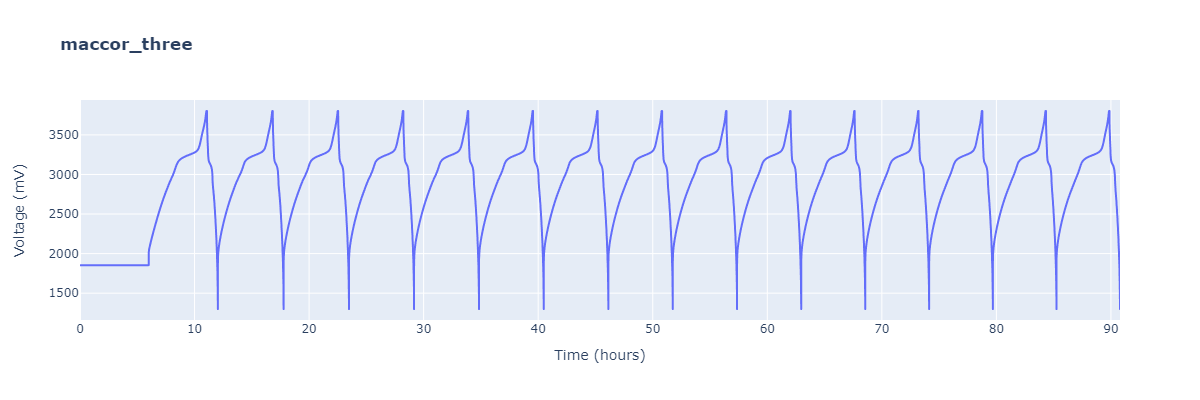

In [16]:
print(f"Available cycles in the file: {c.get_cycle_numbers()}")
plotutils.raw_plot(c, width=1200, height=400)

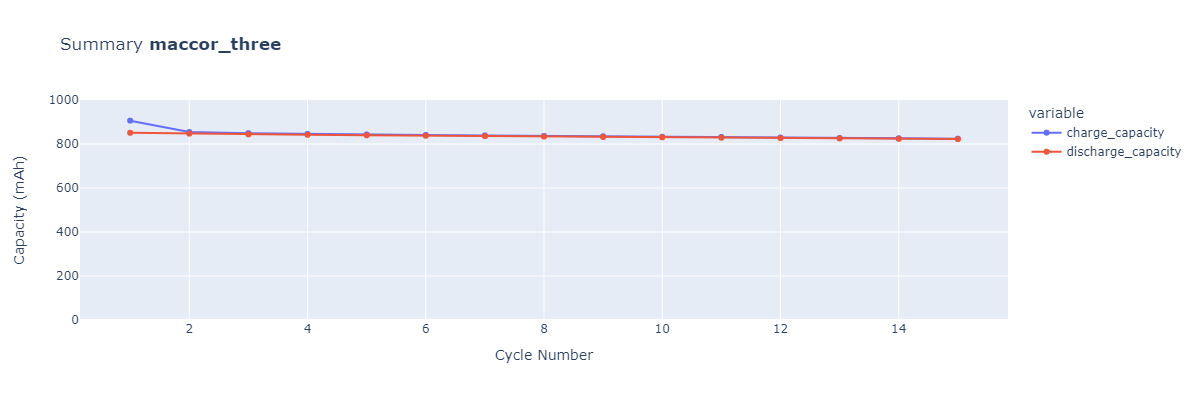

In [17]:
plotutils.summary_plot(c, y="capacities", width=1200, height=400, y_range=[0, 1000])

## NEWARE

Data from Neware testers will be improved soon. Currently, one `model` is implemented ("ONE"). Using the method described above for getting information, currently you will see three model names appear. The "default" is the one that will be picked if no model name is provided ("ONE" for now), while "UIO" is just a nick-name for the "ONE" model.

In [18]:
config = core.instrument_configurations("neware")
print(config["neware_txt"]["__all__"])

['default', 'ONE', 'UIO']

Check the configuration for *model* `ONE`:

In [19]:
print(config["neware_txt"]["ONE"])

{
    'config_params': ModelParameters(
        name='ONE',
        file_info={'raw_extension': 'csv'},
        unit_labels={},
        incremental_unit_labels={},
        normal_headers_renaming_dict={
            'data_point_txt': 'DataPoint',
            'cycle_index_txt': 'Cycle Index',
            'step_index_txt': 'Step Index',
            'current_txt': 'Current(A)',
            'voltage_txt': 'Voltage(V)',
            'charge_capacity_txt': 'Chg. Cap.(Ah)',
            'charge_energy_txt': 'Chg. Energy(Wh)',
            'discharge_capacity_txt': 'DChg. Cap.(Ah)',
            'discharge_energy_txt': 'DChg. Energy(Wh)',
            'datetime_txt': 'Date',
            'step_time_txt': 'Time',
            'dq_dv_txt': 'dQ/dV(mAh/V)',
            'internal_resistance_txt': 'Contact resistance(mO)',
            'power_txt': 'Power(W)',
            'test_time_txt': 'Cumulative Time'
        },
        not_implemented_in_cellpy_yet_renaming_dict={},
        columns_to_keep=[],
        states={
            'column_name': 'Step Type',
            'charge_keys': ['CC Chg'],
            'discharge_keys': ['CC DChg'],
            'rest_keys': ['Rest']
        },
        raw_units={
            'current': 'A',
            'charge': 'Ah',
            'mass': 'g',
            'voltage': 'V',
            'energy': 'Wh',
            'power': 'W',
            'resistance': 'Ohm'
        },
        raw_limits={
            'current_hard': 1e-13,
            'current_soft': 1e-05,
            'stable_current_hard': 2.0,
            'stable_current_soft': 4.0,
            'stable_voltage_hard': 2.0,
            'stable_voltage_soft': 4.0,
            'stable_charge_hard': 0.001,
            'stable_charge_soft': 5.0,
            'ir_change': 1e-05
        },
        formatters={
            'skiprows': 0,
            'sep': None,
            'header': 0,
            'encoding': 'ISO-8859-1',
            'decimal': '.',
            'thousands': None
        },
        meta_keys={},
        pre_processors={},
        post_processors={
            'split_capacity': False,
            'split_current': False,
            'cumulate_capacity_within_cycle': True,
            'set_index': True,
            'rename_headers': True,
            'set_cycle_number_not_zero': False,
            'convert_date_time_to_datetime': True,
            'convert_step_time_to_timedelta': True,
            'convert_test_time_to_timedelta': True
        },
        prefixes={}
    ),
    'doc': 'Class for loading data from Neware txt files.'
}

In [20]:
p = example_data.neware_file_path()
print(f"{p.name=}")

  0%|          | 0.00/358k [00:00<?, ?B/s]

p.name='neware_uio.csv'

In [21]:
c = cellpy.get(p, instrument="neware_txt", mass=2.09)

auto-formatting
(cellpy) - auto-formatting:
  self.sep=','
  self.skiprows=-1
  self.header=0
  self.encoding='UTF-8'

(cellpy) - self.sep=',', self.skiprows=-1, self.header=0, self.encoding='UTF-8', self.decimal='.'
(cellpy) - running post-processor: rename_headers
Index(['DataPoint', 'Cycle Index', 'Step Index', 'Step Type', 'Time',
       'Cumulative Time', 'Current(A)', 'Voltage(V)', 'Capacity(Ah)',
       'Spec. Cap.(mAh/g)', 'Chg. Cap.(Ah)', 'Chg. Spec. Cap.(mAh/g)',
       'DChg. Cap.(Ah)', 'DChg. Spec. Cap.(mAh/g)', 'Energy(Wh)',
       'Spec. Energy(mWh/g)', 'Chg. Energy(Wh)', 'Chg. Spec. Energy(mWh/g)',
       'DChg. Energy(Wh)', 'DChg. Spec. Energy(mWh/g)', 'Date', 'Power(W)',
       'dQ/dV(mAh/V)', 'dQm/dV(mAh/V.g)', 'Contact resistance(mO)',
       'Module start-stop switch'],
      dtype='object')
(cellpy) - running post-processor: cumulate_capacity_within_cycle
(cellpy) - running post-processor: set_index
(cellpy) - running post-processor: convert_date_time_to_datetime
(

Notice that this loader (with the default model) uses the auto-formatting method. The method tries to find out type of delimiter and number of header rows automatically. You can override this by providing the values in the call yourself, for example `c.get(p, instrument="neware_txt", sep=",")`

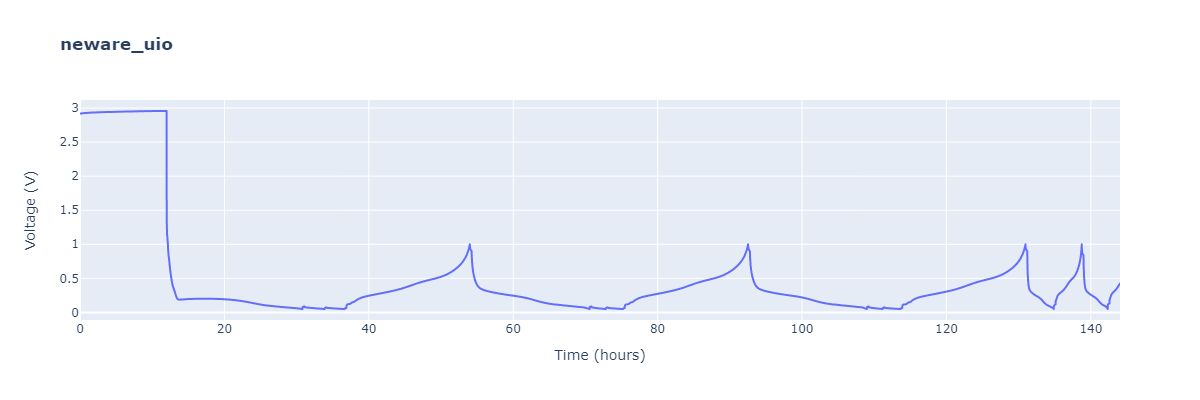

In [22]:
plotutils.raw_plot(c, width=1200, height=400)

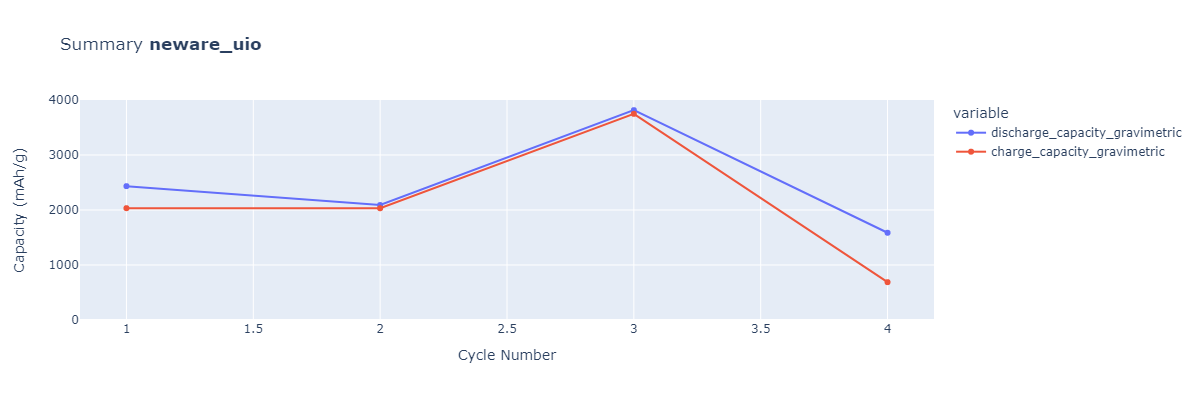

In [23]:
plotutils.summary_plot(c, y="capacities_gravimetric", width=1200, height=400, y_range=[0, 4000])

## Other

The `cellpy` team is working actively on implementing support for more instruments. If the file format is not too challenging, consider using a custom loader (see [custom loaders](07_custom_loaders.ipynb)).